# Churn – Abandon Client Télécom

Auteurs: Julien Billeter et Michael Strefeler

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

random.seed(42)

## Prétraitment des données

### Données

In [3]:
data = pd.read_csv('data/Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Données manquantes

In [5]:
data.isna().sum()
print("Il n'y a pas de données manquantes dans le dataset.")

Il n'y a pas de données manquantes dans le dataset.


### Equilibre des classes

In [9]:
data['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

### Valeurs uniques par attribut

In [8]:
for col in data.columns:
    if data[col].dtype == 'object':
        print(f"{col}: {data[col].unique()}")

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn: ['No' 'Yes']


### Description des variables

In [7]:
description = pd.read_csv('data/Names.csv', delimiter=';', header=None)
description

,0,1
0,customerID,Customer ID
1,gender,Whether the customer is a male or a female
2,SeniorCitizen,Whether the customer is a senior citizen or no...
3,Partner,Whether the customer has a partner or not (Yes...
4,Dependents,Whether the customer has dependents or not (Ye...
5,Tenure,Number of months the customer has stayed with ...
6,PhoneService,Whether the customer has a phone service or no...
7,MultipleLines,Whether the customer has multiple lines or not...
8,InternetService,"Customer's internet service provider (DSL, Fib..."
9,OnlineSecurity,Whether the customer has online security or no...


### Suppression de variables

In [10]:
data.drop(columns=['customerID'], inplace=True)

In [11]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

yes_no_columns = [
    'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn'
]

for col in yes_no_columns:
    data[col] = data[col].map({'Yes': 1, 'No': 0})

# One-hot encoding for multi-category columns (including 3-way columns like InternetService)
multi_category_columns = [
    'gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'Contract', 'PaymentMethod'
]

data = pd.get_dummies(data, columns=multi_category_columns, drop_first=True)

# Final split into features and target
X = data.drop(columns=['Churn'])
y = data['Churn']

In [12]:
X.shape

(7043, 30)

### Mise à l'échelle de certaines variables

In [13]:
# Columns to scale
columns_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])
X = X.dropna()
y = y.loc[X.index]

## Exploration des données

### Matrice de corrélation

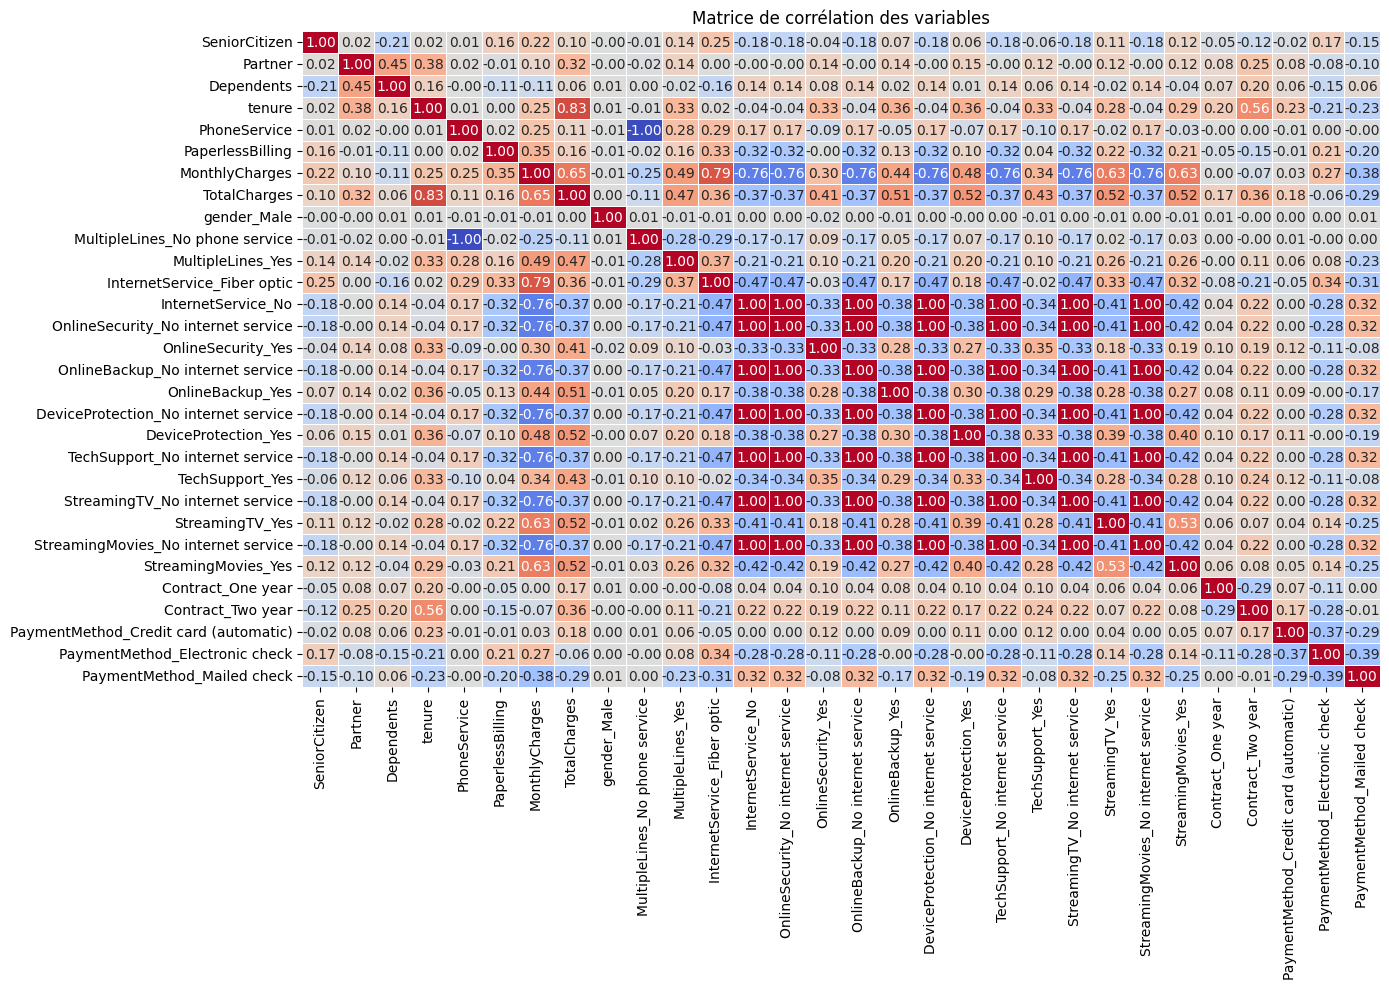

In [308]:
plt.figure(figsize=(14, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=False)
plt.title('Matrice de corrélation des variables')
plt.tight_layout()
plt.show()

## Sélection des 10 attributs les plus importants (par feature importance)

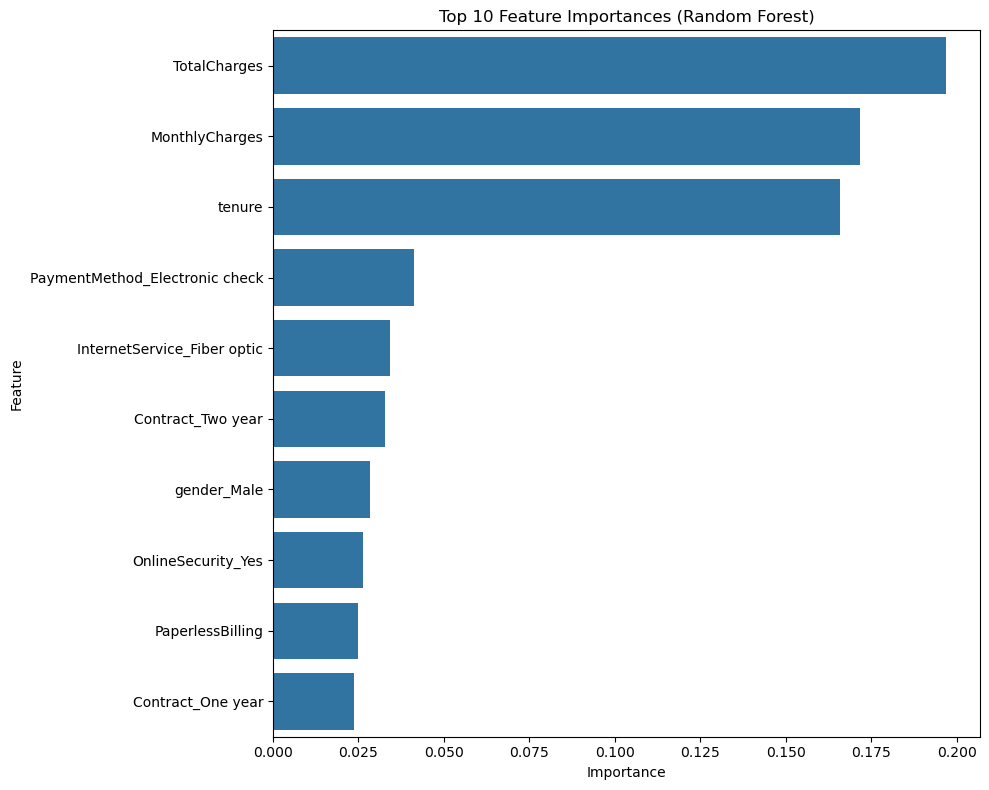

In [16]:
# Train a Random Forest on your data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot top features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(10))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

In [25]:
top_10_features = feat_imp_df['Feature'].head(10).tolist()
X_top10 = X[top_10_features]

'TotalCharges',

'MonthlyCharges',

'tenure',

'PaymentMethod_Electronic check',

'InternetService_Fiber optic',

'Contract_Two year',

'gender_Male',

'OnlineSecurity_Yes',

'PaperlessBilling',

'Contract_One year'

### Séparation train et test

In [26]:
# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X_top10, y, test_size=0.2, random_state=42, stratify=y)

## Modèle transparent : explications ante-hoc

In [34]:
def evaluate_model(y_test, y_pred, title):
    # Évaluation
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Précision: {precision_score(y_test, y_pred):.2f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.2f}")
    print("\nRapport de classification :")
    print(classification_report(y_test, y_pred, target_names=["Stay", "Leave"]))

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    etiquettes = ['Stay', 'Leave']
    df_cm = pd.DataFrame(cm, index=etiquettes, columns=etiquettes)

    plt.figure(figsize=(6, 5))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matrice de confusion ({title})')
    plt.ylabel('Ground truth')
    plt.xlabel('Predictions')
    plt.tight_layout()
    plt.show()

### Classifieur par arbre de décision (Decison Tree, DT)

Accuracy: 0.78
Précision: 0.61
F1-score: 0.54

Rapport de classification :
              precision    recall  f1-score   support

        Stay       0.82      0.89      0.86      1033
       Leave       0.61      0.48      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.68      0.70      1407
weighted avg       0.77      0.78      0.77      1407



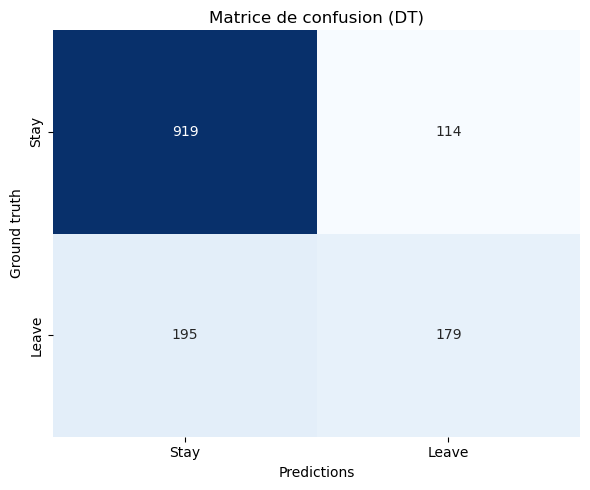

In [35]:
# Entraînement du modèle
tree = DecisionTreeClassifier(random_state=42, max_depth=5)
tree.fit(X_train, y_train)

# Prédictions
y_pred = tree.predict(X_test)

evaluate_model(y_test, y_pred, 'DT')

## Modèle black-box : explications post-hoc

In [40]:
# Convert pandas DataFrame/Series to torch tensors
bool_cols = X_train.select_dtypes(include=['bool']).columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

# Now convert to torch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [41]:
g = torch.Generator()
g.manual_seed(42)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, generator=g)

### Modèle

In [43]:
class ChurnNet(nn.Module):
    def __init__(self, input_dim):
        super(ChurnNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [44]:
model = ChurnNet(X_train_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Entraînement du modèle

In [ ]:
epochs = 100 # 30
loss_epoch = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    loss_epoch.append(average_loss)

    # print(f"Epoch {epoch+1}/{epochs} — Loss: {average_loss:.4f}")

Epoch 1/2000 — Loss: 0.3499
Epoch 2/2000 — Loss: 0.3507
Epoch 3/2000 — Loss: 0.3517
Epoch 4/2000 — Loss: 0.3495
Epoch 5/2000 — Loss: 0.3519
Epoch 6/2000 — Loss: 0.3516
Epoch 7/2000 — Loss: 0.3504
Epoch 8/2000 — Loss: 0.3511
Epoch 9/2000 — Loss: 0.3501
Epoch 10/2000 — Loss: 0.3520
Epoch 11/2000 — Loss: 0.3493
Epoch 12/2000 — Loss: 0.3497
Epoch 13/2000 — Loss: 0.3526
Epoch 14/2000 — Loss: 0.3518
Epoch 15/2000 — Loss: 0.3510
Epoch 16/2000 — Loss: 0.3502
Epoch 17/2000 — Loss: 0.3513
Epoch 18/2000 — Loss: 0.3523
Epoch 19/2000 — Loss: 0.3505
Epoch 20/2000 — Loss: 0.3519
Epoch 21/2000 — Loss: 0.3498
Epoch 22/2000 — Loss: 0.3516
Epoch 23/2000 — Loss: 0.3527
Epoch 24/2000 — Loss: 0.3530
Epoch 25/2000 — Loss: 0.3497
Epoch 26/2000 — Loss: 0.3504
Epoch 27/2000 — Loss: 0.3493
Epoch 28/2000 — Loss: 0.3517
Epoch 29/2000 — Loss: 0.3508
Epoch 30/2000 — Loss: 0.3506
Epoch 31/2000 — Loss: 0.3491
Epoch 32/2000 — Loss: 0.3518
Epoch 33/2000 — Loss: 0.3512
Epoch 34/2000 — Loss: 0.3502
Epoch 35/2000 — Loss: 0

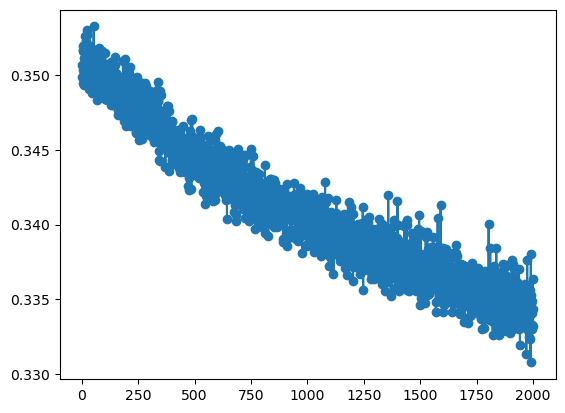

In [65]:
plt.plot(range(1, epochs + 1), loss_epoch, marker='o')

Accuracy: 0.78
Précision: 0.59
F1-score: 0.58

Rapport de classification :
              precision    recall  f1-score   support

        Stay       0.85      0.85      0.85      1033
       Leave       0.59      0.57      0.58       374

    accuracy                           0.78      1407
   macro avg       0.72      0.71      0.72      1407
weighted avg       0.78      0.78      0.78      1407



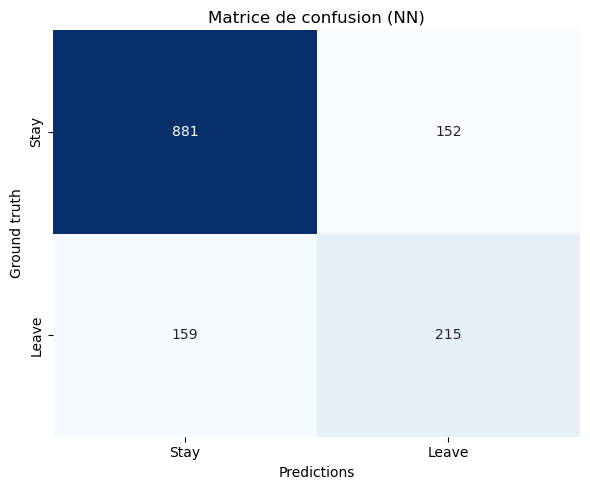

In [64]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).squeeze().numpy()
    y_pred = (y_pred_prob > 0.5).astype(int)
    y_true = y_test_tensor.squeeze().numpy()

evaluate_model(y_true, y_pred, 'NN')

In [47]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_train_tensor).squeeze().numpy()
    y_pred_nn = (y_pred_prob > 0.5).astype(int)

Accuracy: 0.80
Précision: 0.65
F1-score: 0.58

Rapport de classification :
              precision    recall  f1-score   support

        Stay       0.84      0.90      0.87      1033
       Leave       0.65      0.52      0.58       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



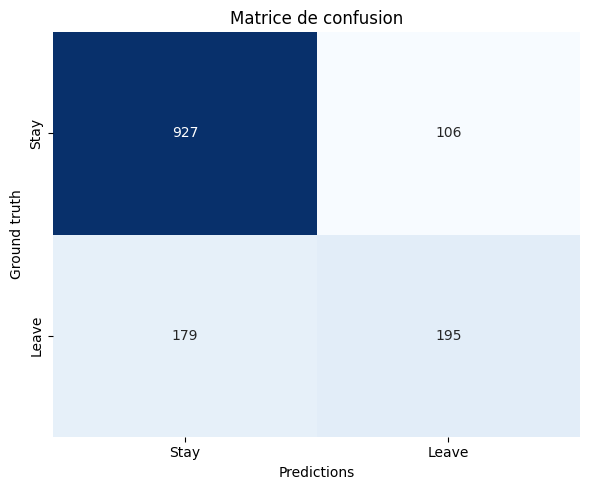

In [322]:
# Entraînement de l'arbre en série
tree = DecisionTreeClassifier(random_state=42, max_depth=5)
tree.fit(X_train, y_pred_nn)

# Prédictions
y_pred_hat = tree.predict(X_test)

evaluate_model(y_test, y_pred_hat)

In [326]:
from sklearn.tree import export_text
rules = export_text(tree, feature_names=X_train.columns.tolist(), class_names=['Stay', 'Leave'])
print(rules)

|--- tenure <= -0.56
|   |--- InternetService_Fiber optic <= 0.50
|   |   |--- PaymentMethod_Electronic check <= 0.50
|   |   |   |--- MonthlyCharges <= -0.81
|   |   |   |   |--- class: Stay
|   |   |   |--- MonthlyCharges >  -0.81
|   |   |   |   |--- TotalCharges <= -0.96
|   |   |   |   |   |--- class: Stay
|   |   |   |   |--- TotalCharges >  -0.96
|   |   |   |   |   |--- class: Stay
|   |   |--- PaymentMethod_Electronic check >  0.50
|   |   |   |--- tenure <= -1.18
|   |   |   |   |--- PaperlessBilling <= 0.50
|   |   |   |   |   |--- class: Stay
|   |   |   |   |--- PaperlessBilling >  0.50
|   |   |   |   |   |--- class: Leave
|   |   |   |--- tenure >  -1.18
|   |   |   |   |--- tenure <= -0.93
|   |   |   |   |   |--- class: Stay
|   |   |   |   |--- tenure >  -0.93
|   |   |   |   |   |--- class: Stay
|   |--- InternetService_Fiber optic >  0.50
|   |   |--- tenure <= -0.73
|   |   |   |--- Contract_One year <= 0.50
|   |   |   |   |--- PaperlessBilling <= 0.50
|   |   |  

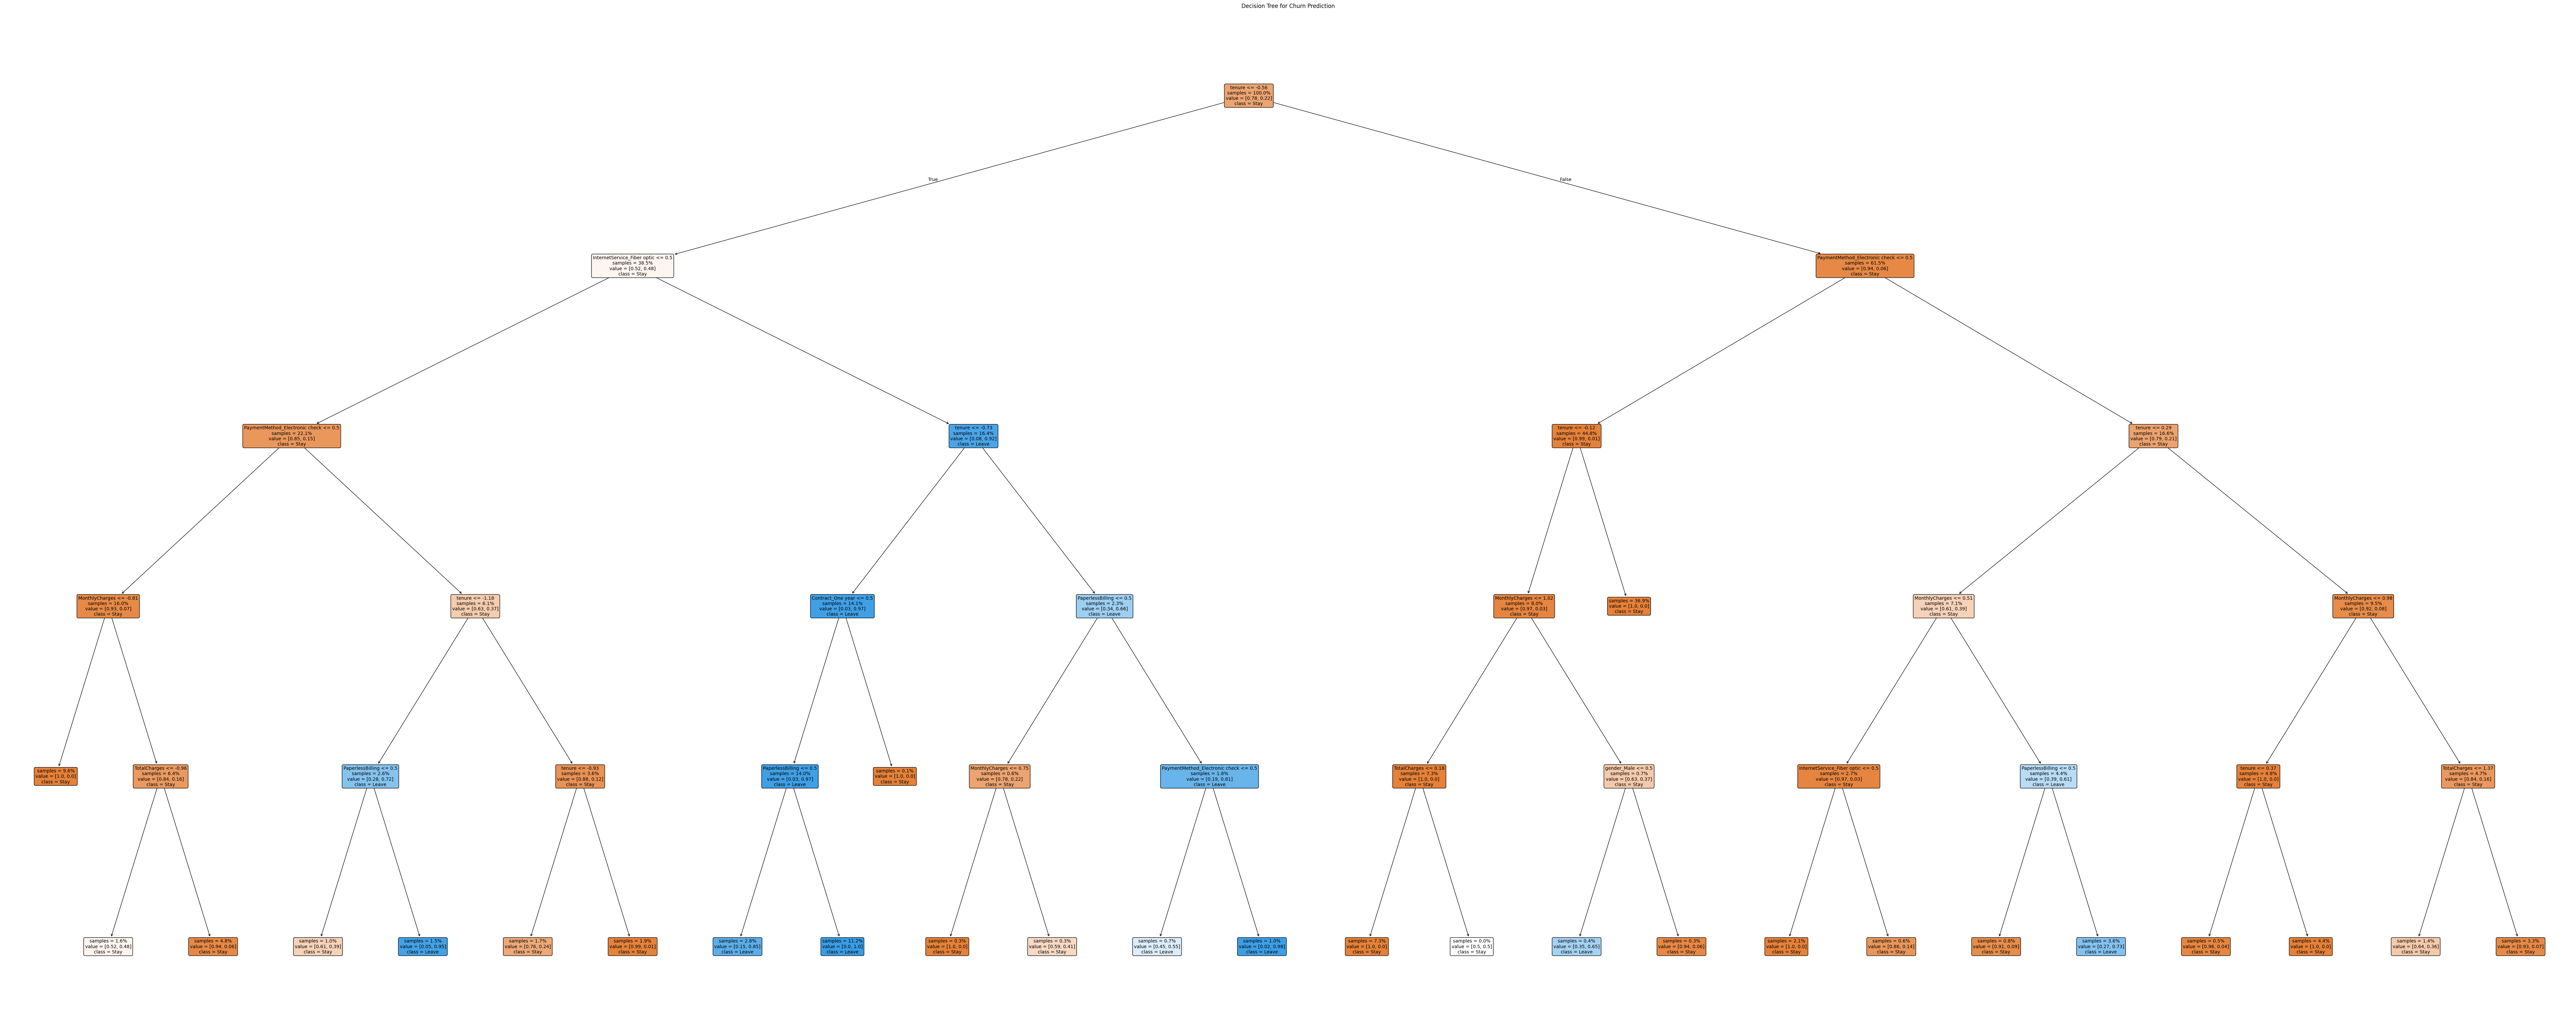

In [343]:
from sklearn.tree import plot_tree

plt.figure(figsize=(100, 40))
plot_tree(
    tree,
    feature_names=X_train.columns,
    class_names=['Stay', 'Leave'],
    filled=True,
    rounded=True,
    fontsize=10,           # Larger font for readability
    proportion=True,       # Show proportions at nodes
    impurity=False,        # Hide impurity for clarity
    precision=2            # Fewer decimals for thresholds
)
plt.title('Decision Tree for Churn Prediction')
plt.show()